# Exploratory Data Analysis and Data Pipeline Preparation for NYC Rolling Sales Data

## 1. Introduction

### Objective
The aim of this notebook is twofold: first, to conduct exploratory data analysis (EDA) on the New York City rolling sales data to uncover general trends in the real estate market across the five boroughs—Manhattan, Bronx, Brooklyn, Queens, and Staten Island. Our analysis will focus on identifying patterns in property sales prices, volumes, and other key metrics. Second, we intend to establish a data pipeline that prepares and processes the data for integration into a Streamlit web application. This NYC real estate sales dashboard will serve as an interactive tool for potential investors, real estate professionals, and policymakers, providing them with actionable insights and a comprehensive overview of the market dynamics.

### Datasets Overview
The primary datasets for this analysis are sourced from the NYC Department of Finance, offering detailed records of property sales transactions across New York City. Additionally, to enhance our analysis and visualization, we incorporate ZIP code geodata, facilitating a geospatial understanding of sales trends.

- **Primary Data Source:** [NYC Department of Finance - Property Rolling Sales Data](https://www.nyc.gov/site/finance/property/property-rolling-sales-data.page) - This source provides datasets for each of the five boroughs, encompassing a variety of attributes such as address, sale price, date of sale, square footage, and property type, across a rolling period of transactions.
- **ZIP Code Geo Data Source:** [Kaggle - NYC Zipcode Geodata](https://www.kaggle.com/datasets/saidakbarp/nyc-zipcode-geodata/data) - This dataset includes geographical information for NYC ZIP codes, which will be used to enhance our spatial analysis and visualizations.

### Background Information
The rolling sales data from NYC is an invaluable resource for dissecting the complex dynamics of one of the world's most prominent real estate markets. Through our EDA, we aim to decrypt the market's behavior, focusing on trends in pricing, volume of sales, and the influential role of location on property values. The subsequent data pipeline developed in this notebook will streamline the data preparation process, ensuring that our Streamlit web application is powered by reliable, clean, and insightful data. This approach not only aids in understanding the current market landscape but also in predicting future trends, thereby supporting informed decision-making in real estate investments and urban development strategies in NYC.


## 2. Setup and Preparation

In this section, we prepare the foundation for our exploratory data analysis (EDA) and pipeline development. The goal is to establish a robust workflow for loading, cleaning, and preprocessing the NYC Rolling Sales Data, which will be utilized in a Streamlit web application focused on real estate sales within New York City. 

### Importing Necessary Libraries

To handle our data efficiently and create compelling visualizations, we'll need to import several Python libraries. These include:

- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **matplotlib & seaborn**: For data visualization.
- **openpyxl**: To read Excel files, as our datasets are in this format.
- **requests**: For loading data from web sources.
- **folium**: For geographic data visualization and creating interactive maps.
- Other supporting libraries for handling dates and plotting adjustments.

In [1]:

# Standard library imports
from datetime import datetime
from io import BytesIO
import calendar
import json


# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from folium.plugins import MarkerCluster
import requests
import openpyxl  
from pandas.tseries.offsets import MonthEnd

# Required for pandas to read Excel files and for loading data from web sources
import folium

### Defining Utility Functions

To streamline our EDA and data preparation process, we've defined several utility functions:

- `load_data(file_name)`: Attempts to load data first from a specified URL and, if unsuccessful, falls back to loading from a local file. This flexibility ensures our analysis can proceed even without internet access or if the remote data source is unavailable.

- `remove_outliers(df, column_name)`: Removes data points that are significantly distant from the mean (more than three standard deviations away). This is crucial for focusing our analysis on typical market behavior and not on extreme anomalies.

- `prepare_time_series(df, date_column)`: Adjusts the sales data to a monthly time series, accounting for partial data in the most recent month. This is instrumental in analyzing trends over time and understanding seasonal patterns in sales volumes.

These functions embody the core tasks in our data pipeline: loading the data, cleansing it of outliers, and structuring it for time-series analysis. Each step is geared toward crafting a clean, reliable dataset that will serve as the backbone for our NYC real estate sales dashboard.

In [2]:
# Ensure matplotlib plots are displayed inline in the Jupyter Notebook
%matplotlib inline

# Set the aesthetics for seaborn plots
sns.set_theme(style="whitegrid")

# Optional: Increase default figure and font sizes for better readability
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


def load_data(file_name):
    """
    Attempts to load data from a URL. If unsuccessful, tries to load from a local file in the project root folder.
    
    Parameters:
    - file_name: str, the name of the file to load (expected to be the same for both the URL and the local path).
    
    Returns:
    - DataFrame containing the loaded data, or None if both methods fail.
    """
    # Define the base URL for the data source
    base_url = "https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales/"
    
    # Construct the full URL by appending the file name to the base URL
    full_url = base_url + file_name
    
    try:
        # Attempt to load the data from the URL
        response = requests.get(full_url)
        response.raise_for_status()  # Raise an HTTPError if the response was an error
        data = pd.read_excel(BytesIO(response.content), engine='openpyxl', header=4)
        print(f"Successfully loaded data from {full_url}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to load data from {full_url}. Error: {e}. Attempting to load from local file...")
        try:
            # If loading from URL fails, attempt to load from a local file
            local_path = file_name  # Assumes the file is in the project root folder with the same file name
            data = pd.read_excel('../' + local_path, engine='openpyxl', header=4)
            print(f"Successfully loaded data from local file: {local_path}")
        except Exception as e:
            print(f"Failed to load data from local file: {local_path}. Error: {e}")
            data = None
    return data


def remove_outliers(df, column_name):
    """
    Remove outliers from a dataframe by excluding any data points that are more than three standard deviations from the mean.

    Parameters:
    df (pandas.DataFrame): The dataframe from which to remove outliers.
    column_name (str): The name of the column to inspect for outliers.

    Returns:
    pandas.DataFrame: A new dataframe with outliers removed.
    """
    mean_val = df[column_name].mean()
    std_val = df[column_name].std()
    low_bound = mean_val - (3 * std_val)
    high_bound = mean_val + (3 * std_val)
    filtered_df = df[(df[column_name] >= low_bound) & (df[column_name] <= high_bound)]
    return filtered_df


def prepare_time_series(df, date_column):
    """
    Prepares and adjusts the time series data for monthly sales volume.
    
    This function extracts the month and year from the sale_date, counts the sales by month,
    and prorates the sales for the most recent month if it is incomplete.
    
    Parameters:
    - df: DataFrame, the dataset containing the sales data.
    - date_column: str, the name of the column in df that contains the sale dates.
    
    Returns:
    - DataFrame with two columns: 'sale_month' and 'adjusted_sales_count', representing the
      adjusted monthly sales volume.
    """
    # Extract month and year from the sale_date
    df['sale_month'] = pd.to_datetime(df[date_column]).dt.to_period('M')
    
    # Count the sales by month and convert the PeriodIndex to DateTimeIndex
    monthly_sales = df.groupby('sale_month').size().to_timestamp()
    
    # Prorate the sales for the most recent month if it is incomplete
    last_month = monthly_sales.index[-1]
    if df[date_column].max() < last_month + MonthEnd(1):
        days_in_month = calendar.monthrange(last_month.year, last_month.month)[1]
        days_passed = (last_month + MonthEnd(1) - df[date_column].max()).days
        prorate_factor = days_in_month / (days_in_month - days_passed)
        monthly_sales[-1] *= prorate_factor
    
    return monthly_sales.reset_index(name='adjusted_sales_count')


## 3. Data Loading

In this crucial phase, we load the NYC Rolling Sales data for each of the five boroughs: Manhattan, Bronx, Brooklyn, Queens, and Staten Island. A resilient data loading strategy is employed to ensure the analysis can proceed under various circumstances:

- **Adaptive Data Source Handling**: Our approach utilizes try-except blocks to flexibly load data. The preference is to access local copies of the datasets to speed up the process and ensure reliability. However, should local files be missing or outdated, the script automatically attempts to fetch the data directly from the NYC Department of Finance's website.

- **Dataset Organization**: We organize the data into separate Pandas DataFrames, one for each borough. This structure facilitates focused analysis on individual boroughs and comparative insights across them.

### Implementation Details

- **Local and Web Loading**: The `load_data` function encapsulates the logic for both local and web data retrieval, gracefully handling any errors encountered during the process.
- **DataFrame Initialization**: A dictionary named `borough_dataframes` serves as a container for the borough-specific DataFrames, enabling efficient data manipulation and access in subsequent analysis stages.


In [3]:
# List of file names for each borough's rolling sales data
file_names = {
    "Manhattan": "rollingsales_manhattan.xlsx",
    "Bronx": "rollingsales_bronx.xlsx",
    "Brooklyn": "rollingsales_brooklyn.xlsx",
    "Queens": "rollingsales_queens.xlsx",
    "Staten Island": "rollingsales_statenisland.xlsx"
}

# Initialize an empty dictionary to store the dataframes
borough_dataframes = {}

# Loop through the file names, loading each dataset into a separate dataframe
for borough, file_name in file_names.items():
    print(f"Loading data for {borough}...")
    df = load_data(file_name)
    if df is not None:
        borough_dataframes[borough] = df
        print(f"Data for {borough} loaded successfully.\n")
    else:
        print(f"Failed to load data for {borough}.\n")

# At this point, borough_dataframes dictionary contains a dataframe for each borough
# You can access each dataframe using the borough name as the key, for example:
# manhattan_df = borough_dataframes["Manhattan"]


Loading data for Manhattan...
Successfully loaded data from https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_manhattan.xlsx
Data for Manhattan loaded successfully.

Loading data for Bronx...
Successfully loaded data from https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_bronx.xlsx
Data for Bronx loaded successfully.

Loading data for Brooklyn...
Successfully loaded data from https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_brooklyn.xlsx
Data for Brooklyn loaded successfully.

Loading data for Queens...
Successfully loaded data from https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_queens.xlsx
Data for Queens loaded successfully.

Loading data for Staten Island...
Successfully loaded data from https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_statenisland.xlsx
Data for Staten Island loaded successfully.



## 4. Data Cleaning and Preprocessing

Before diving into analysis, it's vital to ensure our dataset is clean and structured properly. This stage lays the foundation for accurate and insightful analysis.

### 4.1 Inspect Data

Initially, we inspect each borough's data to understand its structure, identify missing values, and note any inconsistencies. This inspection covers basic information such as data types, non-null counts, and statistical summaries, offering a preliminary view of the data's characteristics and quality.

By reviewing samples from each dataset, we also gain insights into the data's real-world representation, allowing us to tailor our cleaning and preprocessing steps more effectively.

In [4]:
# Inspect each DataFrame
for borough, df in borough_dataframes.items():
    print(f"Data Overview for {borough}:")
    print("Information:")
    df.info()
    print("\nDescription:")
    display(df.describe())
    display(df.sample(10))
    print("-" * 50)


Data Overview for Manhattan:
Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16784 entries, 0 to 16783
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         16784 non-null  int64         
 1   NEIGHBORHOOD                    16784 non-null  object        
 2   BUILDING CLASS CATEGORY         16784 non-null  object        
 3   TAX CLASS AT PRESENT            16769 non-null  object        
 4   BLOCK                           16784 non-null  int64         
 5   LOT                             16784 non-null  int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       16769 non-null  object        
 8   ADDRESS                         16784 non-null  object        
 9   APARTMENT NUMBER                7740 non-null   object        
 10  ZIP CODE                    

,BOROUGH,BLOCK,LOT,EASEMENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,16784.0,16784.000000,16784.000000,0.0,16784.000000,8666.000000,2160.000000,9289.000000,1537.000000,1.537000e+03,15031.000000,16784.000000,1.678400e+04,16784
mean,1.0,1110.049750,726.782173,NaN,10032.485164,9.170782,2.585648,9.156960,7349.201692,6.921687e+04,1954.372231,2.095091,2.862134e+06,2023-08-18 13:13:31.630124032
min,1.0,11.000000,1.000000,NaN,10001.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1800.000000,1.000000,0.000000e+00,2023-03-01 00:00:00
25%,1.0,748.000000,29.000000,NaN,10013.000000,1.000000,0.000000,1.000000,1886.000000,4.300000e+03,1924.000000,2.000000,3.500000e+05,2023-05-23 00:00:00
50%,1.0,1171.000000,1002.000000,NaN,10022.000000,1.000000,1.000000,1.000000,2523.000000,8.825000e+03,1956.000000,2.000000,9.250000e+05,2023-08-14 00:00:00
75%,1.0,1466.000000,1190.000000,NaN,10028.000000,1.000000,1.000000,1.000000,7541.000000,4.357800e+04,1986.000000,2.000000,2.175000e+06,2023-11-10 00:00:00
max,1.0,2250.000000,9079.000000,NaN,10463.000000,616.000000,390.000000,618.000000,738000.000000,2.400000e+06,2023.000000,4.000000,9.630000e+08,2024-02-29 00:00:00
std,0.0,542.602524,868.427664,NaN,44.995867,43.615232,16.467804,43.163021,26800.968609,1.429877e+05,37.829192,0.483058,1.631541e+07,NaN


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASEMENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
13275,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1548,1327,NaN,R4,"305 EAST 85TH ST, 9D",9D,...,1.0,NaN,1.0,NaN,NaN,2008.0,2,R4,3150000,2023-04-24
2660,1,GRAMERCY,10 COOPS - ELEVATOR APARTMENTS,2,896,32,NaN,D4,"230 EAST 15TH STREET, 6F",NaN,...,NaN,NaN,NaN,NaN,NaN,1961.0,2,D4,489000,2023-05-23
8415,1,MORNINGSIDE HEIGHTS,13 CONDOS - ELEVATOR APARTMENTS,2,1977,1152,NaN,R4,"543 WEST 122ND, 24A",24A,...,1.0,NaN,1.0,NaN,NaN,2018.0,2,R4,3850000,2023-11-03
7040,1,MIDTOWN EAST,10 COOPS - ELEVATOR APARTMENTS,2,1366,25,NaN,D4,"50 SUTTON PLACE SOUTH, 18AB",NaN,...,NaN,NaN,NaN,NaN,NaN,1955.0,2,D4,46000,2023-03-21
10372,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1382,69,NaN,D4,"860 FIFTH AVENUE, 9D",NaN,...,NaN,NaN,NaN,NaN,NaN,1950.0,2,D4,447000,2024-01-29
9125,1,SOHO,10 COOPS - ELEVATOR APARTMENTS,2,483,13,NaN,D0,"514 BROADWAY, 2GH",NaN,...,NaN,NaN,NaN,NaN,NaN,1900.0,2,D0,3810000,2023-09-06
14784,1,UPPER WEST SIDE (59-79),17 CONDO COOPS,2,1158,1107,NaN,R9,"180 WEST END AVENUE, 5L",NaN,...,NaN,NaN,NaN,NaN,NaN,1965.0,2,R9,1175000,2023-12-06
10269,1,UPPER EAST SIDE (59-79),09 COOPS - WALKUP APARTMENTS,2C,1388,63,NaN,C6,"14 EAST 74TH STREET, 2",NaN,...,NaN,NaN,NaN,NaN,NaN,1930.0,2,C6,0,2024-02-24
13641,1,UPPER WEST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1119,29,NaN,D4,"65 CENTRAL PARK WEST, 6FG",NaN,...,NaN,NaN,NaN,NaN,NaN,1929.0,2,D4,2350000,2023-06-05
914,1,CHELSEA,21 OFFICE BUILDINGS,4,795,28,NaN,O6,111 WEST 19TH STREET,NaN,...,0.0,8.0,8.0,18400.0,165513.0,1901.0,4,O6,0,2023-12-21


--------------------------------------------------
Data Overview for Bronx:
Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5745 entries, 0 to 5744
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         5745 non-null   int64         
 1   NEIGHBORHOOD                    5745 non-null   object        
 2   BUILDING CLASS CATEGORY         5745 non-null   object        
 3   TAX CLASS AT PRESENT            5745 non-null   object        
 4   BLOCK                           5745 non-null   int64         
 5   LOT                             5745 non-null   int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       5745 non-null   object        
 8   ADDRESS                         5745 non-null   object        
 9   APARTMENT NUMBER                526 non-null    obj

,BOROUGH,BLOCK,LOT,EASEMENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,5745.0,5745.000000,5745.000000,0.0,5745.000000,4729.000000,4265.000000,4765.000000,4.229000e+03,4.229000e+03,5151.000000,5745.000000,5.745000e+03,5745
mean,2.0,4279.400522,304.832202,NaN,10464.283029,4.207655,1.302227,5.341448,3.729908e+04,1.269502e+04,1946.375849,1.511923,7.838157e+05,2023-08-23 04:10:24.125326336
min,2.0,2265.000000,1.000000,NaN,10451.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1870.000000,1.000000,0.000000e+00,2023-03-01 00:00:00
25%,2.0,3334.000000,22.000000,NaN,10461.000000,1.000000,0.000000,1.000000,2.167000e+03,1.560000e+03,1925.000000,1.000000,0.000000e+00,2023-05-26 00:00:00
50%,2.0,4266.000000,49.000000,NaN,10465.000000,2.000000,0.000000,2.000000,2.500000e+03,2.183000e+03,1941.000000,1.000000,2.890000e+05,2023-08-18 00:00:00
75%,2.0,5361.000000,137.000000,NaN,10469.000000,2.000000,0.000000,2.000000,3.740000e+03,3.132000e+03,1961.000000,2.000000,7.190000e+05,2023-11-17 00:00:00
max,2.0,5957.000000,5377.000000,NaN,10475.000000,1019.000000,252.000000,1019.000000,5.799632e+06,1.598812e+06,2023.000000,4.000000,1.037419e+08,2024-02-29 00:00:00
std,0.0,1075.113824,741.731116,NaN,5.600683,25.429767,16.793075,29.839803,4.264916e+05,9.893866e+04,29.525248,0.818424,3.747109e+06,NaN


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASEMENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
5400,2,WILLIAMSBRIDGE,01 ONE FAMILY DWELLINGS,1,4687,6,NaN,A2,945 EAST 216 STREET,NaN,...,1.0,0.0,1.0,5466.0,1858.0,1920.0,1,A2,699000,2023-03-30
1998,2,MELROSE/CONCOURSE,03 THREE FAMILY DWELLINGS,1,2432,94,NaN,C0,998 FINDLAY AVENUE,NaN,...,3.0,0.0,3.0,1962.0,3382.0,1920.0,1,C0,1020000,2023-12-11
4626,2,SOUNDVIEW,07 RENTALS - WALKUP APARTMENTS,2A,3742,69,NaN,C3,1123 MANOR AVENUE,NaN,...,4.0,0.0,4.0,2500.0,3280.0,1926.0,2,C3,0,2023-09-19
5104,2,WAKEFIELD,01 ONE FAMILY DWELLINGS,1,5029,34,NaN,A5,4226 MURDOCK AVENUE,NaN,...,1.0,0.0,1.0,1658.0,1746.0,1955.0,1,A5,575000,2023-09-25
4282,2,SCHUYLERVILLE/PELHAM BAY,03 THREE FAMILY DWELLINGS,1,5367,23,NaN,C0,3070 CODDINGTON AVENUE,NaN,...,3.0,0.0,3.0,2500.0,2304.0,1920.0,1,C0,775000,2023-11-06
1115,2,COUNTRY CLUB,01 ONE FAMILY DWELLINGS,1,5465,41,NaN,A5,1006 CLARENCE AVE,NaN,...,1.0,0.0,1.0,1706.0,1692.0,1950.0,1,A5,595000,2023-06-05
1255,2,CROTONA PARK,09 COOPS - WALKUP APARTMENTS,2,2966,17,NaN,C6,"1500 BOSTON ROAD, 68",NaN,...,NaN,NaN,NaN,NaN,NaN,1933.0,2,C6,105000,2024-01-19
3120,2,PARKCHESTER,13 CONDOS - ELEVATOR APARTMENTS,2,3944,3162,NaN,R4,"2240 EAST TREMONT AVENUE, MA",MA,...,1.0,NaN,1.0,NaN,NaN,NaN,2,R4,0,2023-06-27
2314,2,MORRIS PARK/VAN NEST,10 COOPS - ELEVATOR APARTMENTS,2,4289,20,NaN,D4,"768 BRADY AVE, 245",NaN,...,NaN,NaN,NaN,NaN,NaN,1933.0,2,D4,240000,2023-08-03
4169,2,SCHUYLERVILLE/PELHAM BAY,02 TWO FAMILY DWELLINGS,1,4157,6,NaN,B1,2855 MIDDLETOWN ROAD,NaN,...,2.0,0.0,2.0,2484.0,2030.0,1955.0,1,B1,775000,2023-03-29


--------------------------------------------------
Data Overview for Brooklyn:
Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         21152 non-null  int64         
 1   NEIGHBORHOOD                    21152 non-null  object        
 2   BUILDING CLASS CATEGORY         21152 non-null  object        
 3   TAX CLASS AT PRESENT            21112 non-null  object        
 4   BLOCK                           21152 non-null  int64         
 5   LOT                             21152 non-null  int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       21112 non-null  object        
 8   ADDRESS                         21152 non-null  object        
 9   APARTMENT NUMBER                5371 non-null 

,BOROUGH,BLOCK,LOT,EASEMENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,21152.0,21152.000000,21152.000000,0.0,21151.000000,17481.000000,14173.000000,18503.000000,1.315100e+04,13151.000000,19841.000000,21152.000000,2.115200e+04,21152
mean,3.0,4417.310656,354.656912,NaN,11219.856413,3.892970,0.268327,3.883478,3.452484e+03,5784.616075,1947.045965,1.656581,1.067326e+06,2023-08-24 20:02:57.004538624
min,3.0,1.000000,1.000000,NaN,10012.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1800.000000,1.000000,0.000000e+00,2023-03-01 00:00:00
25%,3.0,1833.000000,24.000000,NaN,11210.000000,1.000000,0.000000,1.000000,1.900000e+03,1658.500000,1920.000000,1.000000,0.000000e+00,2023-05-30 00:00:00
50%,3.0,4911.500000,52.000000,NaN,11219.000000,2.000000,0.000000,2.000000,2.050000e+03,2337.000000,1931.000000,1.000000,4.850000e+05,2023-08-23 00:00:00
75%,3.0,6678.000000,1002.000000,NaN,11230.000000,2.000000,0.000000,2.000000,2.659500e+03,3198.000000,1967.000000,2.000000,1.150000e+06,2023-11-20 00:00:00
max,3.0,8955.000000,8005.000000,NaN,11249.000000,798.000000,159.000000,800.000000,1.479935e+06,869038.000000,2023.000000,4.000000,3.177926e+08,2024-02-29 00:00:00
std,0.0,2674.496035,545.313930,NaN,18.585089,28.811683,1.864530,28.066305,1.863045e+04,34373.324362,40.061729,0.883059,4.500049e+06,NaN


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASEMENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
18185,3,RED HOOK,01 ONE FAMILY DWELLINGS,1,588,1,NaN,S1,199 RICHARDS ST,NaN,...,1.0,1.0,2.0,2375.0,2580.0,1925.0,1,S1,0,2023-06-15
18383,3,SHEEPSHEAD BAY,01 ONE FAMILY DWELLINGS,1,7419,10,NaN,A5,1724 AVENUE X,NaN,...,1.0,0.0,1.0,2100.0,1685.0,1930.0,1,A5,1335000,2024-01-16
6713,3,CARROLL GARDENS,02 TWO FAMILY DWELLINGS,1,365,46,NaN,B9,29 3RD PLACE,NaN,...,2.0,0.0,2.0,2000.0,2392.0,1901.0,1,B9,2660000,2023-06-28
8601,3,CYPRESS HILLS,10 COOPS - ELEVATOR APARTMENTS,2,3886,10,NaN,D4,"224 HIGHLAND BOULEVARD, 514",NaN,...,NaN,NaN,NaN,NaN,NaN,1940.0,2,D4,0,2023-12-29
9295,3,DYKER HEIGHTS,01 ONE FAMILY DWELLINGS,1,6167,63,NaN,A5,1335 71ST STREET,NaN,...,1.0,0.0,1.0,2000.0,1320.0,1910.0,1,A5,0,2024-01-08
10865,3,FLATBUSH-CENTRAL,46 CONDO STORE BUILDINGS,4,5141,1004,NaN,RK,"651 CONEY ISLAND AVENUE, CM 1",CM 1,...,NaN,1.0,1.0,NaN,NaN,2007.0,4,RK,0,2023-04-24
13578,3,GREENPOINT,02 TWO FAMILY DWELLINGS,1,2829,20,NaN,B1,143 KINGSLAND AVENUE,NaN,...,2.0,0.0,2.0,2096.0,1976.0,1910.0,1,B1,900000,2023-08-01
14691,3,MARINE PARK,01 ONE FAMILY DWELLINGS,1,7691,140,NaN,A5,1556 MARINE PKWY,NaN,...,1.0,0.0,1.0,1326.0,1152.0,1925.0,1,A5,655000,2023-05-24
14883,3,MARINE PARK,02 TWO FAMILY DWELLINGS,1,7694,90,NaN,B1,3132 KINGS HIGHWAY,NaN,...,2.0,0.0,2.0,1873.0,1872.0,1940.0,1,B1,0,2023-09-06
9351,3,DYKER HEIGHTS,02 TWO FAMILY DWELLINGS,1,5764,48,NaN,B1,978 67TH STREET,NaN,...,2.0,0.0,2.0,2000.0,1872.0,1955.0,1,B1,0,2023-10-20


--------------------------------------------------
Data Overview for Queens:
Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23496 entries, 0 to 23495
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         23496 non-null  int64         
 1   NEIGHBORHOOD                    23496 non-null  object        
 2   BUILDING CLASS CATEGORY         23496 non-null  object        
 3   TAX CLASS AT PRESENT            23491 non-null  object        
 4   BLOCK                           23496 non-null  int64         
 5   LOT                             23496 non-null  int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       23491 non-null  object        
 8   ADDRESS                         23496 non-null  object        
 9   APARTMENT NUMBER                3541 non-null   

,BOROUGH,BLOCK,LOT,EASEMENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,23496.0,23496.000000,23496.000000,0.0,23496.000000,18234.000000,15949.000000,18859.000000,15324.000000,15324.000000,22566.000000,23496.000000,2.349600e+04,23496
mean,4.0,6432.766258,239.965483,NaN,11364.711313,1.736756,0.176814,1.828729,3825.624641,2508.582550,1951.907294,1.507448,6.561423e+05,2023-08-24 09:15:56.077630464
min,4.0,6.000000,1.000000,NaN,10030.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1802.000000,1.000000,0.000000e+00,2023-03-01 00:00:00
25%,4.0,2476.000000,16.000000,NaN,11358.000000,1.000000,0.000000,1.000000,2142.000000,1283.000000,1930.000000,1.000000,0.000000e+00,2023-05-26 00:00:00
50%,4.0,5684.000000,40.000000,NaN,11374.000000,1.000000,0.000000,1.000000,2831.000000,1702.000000,1949.000000,1.000000,3.420000e+05,2023-08-23 00:00:00
75%,4.0,9850.000000,94.000000,NaN,11418.000000,2.000000,0.000000,2.000000,4000.000000,2366.000000,1961.000000,2.000000,7.910000e+05,2023-11-16 00:00:00
max,4.0,16350.000000,7114.000000,NaN,11697.000000,371.000000,123.000000,372.000000,424959.000000,407140.000000,2023.000000,4.000000,3.177926e+08,2024-02-29 00:00:00
std,0.0,4387.821869,493.961259,NaN,120.407951,6.456621,1.770104,6.575507,7121.197762,8725.000988,30.041440,0.774808,3.128355e+06,NaN


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASEMENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
6833,4,FLUSHING-NORTH,02 TWO FAMILY DWELLINGS,1,6366,12,NaN,B2,58-42 136TH STREET,NaN,...,2.0,0.0,2.0,3000.0,1664.0,1925.0,1,B2,0,2023-12-14
21517,4,SPRINGFIELD GARDENS,07 RENTALS - WALKUP APARTMENTS,2A,13049,58,NaN,C2,179-26 142 AVE,NaN,...,5.0,0.0,5.0,4897.0,1784.0,1930.0,2,C2,997631,2023-08-24
14941,4,LONG ISLAND CITY,13 CONDOS - ELEVATOR APARTMENTS,2,373,1038,NaN,R4,"37-26 32ND STREET, S-2I",S-2I,...,1.0,NaN,1.0,NaN,NaN,2020.0,2,R4,697501,2023-11-29
13958,4,LAURELTON,01 ONE FAMILY DWELLINGS,1,12894,2,NaN,A1,218-15 131ST AVE,NaN,...,1.0,0.0,1.0,4320.0,1788.0,1930.0,1,A1,485000,2023-08-24
20887,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11823,15,NaN,A5,149-43 122ND STREET,NaN,...,1.0,0.0,1.0,2025.0,1760.0,1945.0,1,A5,0,2023-06-29
10688,4,GLENDALE,01 ONE FAMILY DWELLINGS,1,3634,46,NaN,A5,68-36 65TH PLACE,NaN,...,1.0,0.0,1.0,2000.0,1248.0,1925.0,1,A5,772500,2023-03-09
12140,4,HOWARD BEACH,10 COOPS - ELEVATOR APARTMENTS,2,11434,25,NaN,D4,"89-35 155TH AVENUE, 66",NaN,...,NaN,NaN,NaN,NaN,NaN,1962.0,2,D4,0,2023-10-19
5494,4,FAR ROCKAWAY,01 ONE FAMILY DWELLINGS,1,15774,70,NaN,A2,24-81 COLLIER AVENUE,NaN,...,1.0,0.0,1.0,4800.0,960.0,1930.0,1,A2,0,2023-11-21
19526,4,ROSEDALE,01 ONE FAMILY DWELLINGS,1,13573,3,NaN,B3,141-18 247TH STREET,NaN,...,2.0,0.0,2.0,5000.0,2996.0,1945.0,1,A2,1365000,2023-07-18
19203,4,RIDGEWOOD,07 RENTALS - WALKUP APARTMENTS,2A,3489,10,NaN,C2,2018 PALMETTO STREET,NaN,...,6.0,0.0,6.0,2742.0,5600.0,1930.0,2,C2,1230000,2023-12-01


--------------------------------------------------
Data Overview for Staten Island:
Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6846 entries, 0 to 6845
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         6846 non-null   int64         
 1   NEIGHBORHOOD                    6846 non-null   object        
 2   BUILDING CLASS CATEGORY         6846 non-null   object        
 3   TAX CLASS AT PRESENT            6846 non-null   object        
 4   BLOCK                           6846 non-null   int64         
 5   LOT                             6846 non-null   int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       6846 non-null   object        
 8   ADDRESS                         6846 non-null   object        
 9   APARTMENT NUMBER                377 non-nul

,BOROUGH,BLOCK,LOT,EASEMENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,6846.0,6846.000000,6846.000000,0.0,6838.000000,6706.000000,6158.000000,6731.000000,6.133000e+03,6133.000000,6346.000000,6846.000000,6.846000e+03,6846
mean,5.0,3378.249781,194.503360,NaN,10308.020913,1.205189,0.059597,1.255237,6.447847e+03,1851.635741,1968.856287,1.157464,4.485203e+05,2023-08-12 05:43:54.531112960
min,5.0,1.000000,1.000000,NaN,10301.000000,0.000000,0.000000,0.000000,2.000000e+02,0.000000,1884.000000,1.000000,0.000000e+00,2023-03-01 00:00:00
25%,5.0,1061.000000,24.000000,NaN,10305.000000,1.000000,0.000000,1.000000,2.500000e+03,1160.000000,1950.000000,1.000000,0.000000e+00,2023-05-25 00:00:00
50%,5.0,3252.500000,54.000000,NaN,10308.000000,1.000000,0.000000,1.000000,3.920000e+03,1558.000000,1975.000000,1.000000,4.250000e+05,2023-08-10 00:00:00
75%,5.0,5442.000000,128.000000,NaN,10312.000000,1.000000,0.000000,2.000000,5.000000e+03,2184.000000,1989.000000,1.000000,7.000000e+05,2023-10-30 00:00:00
max,5.0,8048.000000,5342.000000,NaN,10314.000000,150.000000,12.000000,150.000000,9.166500e+06,233560.000000,2023.000000,4.000000,4.200000e+07,2024-02-29 00:00:00
std,0.0,2346.066077,446.220815,NaN,4.186524,2.124382,0.385949,2.133700,1.180898e+05,4189.978218,30.387974,0.595362,7.735762e+05,NaN


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASEMENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
379,5,ARDEN HEIGHTS,01 ONE FAMILY DWELLINGS,1,6055,87,NaN,A5,186 ROSEDALE AVENUE,NaN,...,1.0,0.0,1.0,1060.0,1200.0,1988.0,1,A5,0,2023-06-14
3225,5,MIDLAND BEACH,02 TWO FAMILY DWELLINGS,1,3651,61,NaN,B2,380 BUEL AVENUE,NaN,...,2.0,0.0,2.0,4717.0,2616.0,1960.0,1,B2,0,2023-06-21
2493,5,GREAT KILLS,31 COMMERCIAL VACANT LAND,4,5298,80,NaN,V1,N/A WIMAN AVENUE,NaN,...,0.0,0.0,0.0,1200.0,0.0,NaN,4,V1,1000000,2023-12-12
5088,5,ROSEBANK,01 ONE FAMILY DWELLINGS,1,3070,51,NaN,A1,14 HIGH STREET,NaN,...,1.0,0.0,1.0,2900.0,1062.0,1910.0,1,A1,0,2023-10-05
4938,5,RICHMONDTOWN,01 ONE FAMILY DWELLINGS,1,4377,43,NaN,A2,172 AMBER STREET,NaN,...,1.0,0.0,1.0,4100.0,1056.0,1960.0,1,A2,0,2023-10-13
62,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,6286,15,NaN,A1,393 LAMONT AVENUE,NaN,...,1.0,0.0,1.0,8300.0,2920.0,1975.0,1,A1,950000,2023-09-20
4330,5,OAKWOOD-BEACH,01 ONE FAMILY DWELLINGS,1,4718,8,NaN,A2,273 CHESTERTON AVENUE,NaN,...,1.0,0.0,1.0,4000.0,1000.0,1960.0,1,A2,665000,2023-07-18
4204,5,NEW SPRINGVILLE,12 CONDOS - WALKUP APARTMENTS,2,2360,1063,NaN,R2,"1298 ROCKLAND AVENUE, 2G",2G,...,1.0,NaN,1.0,NaN,NaN,1973.0,2,R2,0,2023-08-25
4466,5,OAKWOOD-BEACH,05 TAX CLASS 1 VACANT LAND,1B,4792,119,NaN,V0,47 TARLTON STREET,NaN,...,0.0,0.0,0.0,4000.0,0.0,NaN,1,V0,0,2023-10-30
3538,5,NEW BRIGHTON-ST. GEORGE,10 COOPS - ELEVATOR APARTMENTS,2,1,216,NaN,D0,"10 BAY STREET LANDING, A5D",NaN,...,NaN,NaN,NaN,NaN,NaN,1984.0,2,D0,306425,2023-08-09


--------------------------------------------------


### 4.2 Remove Unnecessary Columns

After inspecting the datasets, we've identified several columns that do not align with the objectives of our Streamlit web application. To streamline our analysis and focus on the most relevant information, we decide to remove these columns:

- **Granular Identifiers**: `BLOCK` and `LOT` are too detailed for our broad analysis.
- **Legal Details**: The `EASEMENT` column, related to property rights, is not relevant to our goals.
- **Detailed Location Info**: `ADDRESS` and `APARTMENT NUMBER` are unnecessary, as we focus on trends at a higher geographical level.
- **Tax Classification**: `TAX CLASS AT PRESENT` and `TAX CLASS AT TIME OF SALE` are excluded to simplify our initial analysis.

This step reduces dataset complexity, making it more manageable and aligned with our analysis objectives.



In [5]:
# Define a list of columns to remove, aligned with our analysis goals
columns_to_remove = ['BLOCK', 'LOT', 'EASEMENT', 'ADDRESS', 'APARTMENT NUMBER', 'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE']

# Loop through each borough's DataFrame and remove the specified unnecessary columns
for borough, df in borough_dataframes.items():
    df.drop(columns=columns_to_remove, errors='ignore', inplace=True)  # Use errors='ignore' to gracefully handle missing columns
    borough_dataframes[borough] = df

# Verification: Print the columns of the Manhattan DataFrame to confirm removal
print("Columns in the Manhattan DataFrame after removal:")
print(borough_dataframes['Manhattan'].columns)


Columns in the Manhattan DataFrame after removal:
Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'BUILDING CLASS AT PRESENT', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')


### 4.3 Handle Missing Values

Dealing with missing data is crucial for maintaining the integrity of our analysis. Our approach varies based on the significance of the column:

- **Property Characteristics**: For `RESIDENTIAL UNITS`, `COMMERCIAL UNITS`, `LAND SQUARE FEET`, and `GROSS SQUARE FEET`, we impute missing values with the neighborhood average, reflecting a realistic approximation.
- **Property Classification**: Rows missing the `BUILDING CLASS AT PRESENT` are removed to ensure classification accuracy.
- **Realistic Transactions**: We exclude transactions with a `SALE PRICE` of $0 or unreasonably low values, focusing on genuine market activities.

These steps enhance our dataset's quality, ensuring it accurately represents the NYC real estate market for our application.

In [6]:
# Check for missing values in each borough's DataFrame
for borough, df in borough_dataframes.items():
    print(f"Missing values in {borough} DataFrame:")
    print(df.isnull().sum())
    print("-" * 50)

Missing values in Manhattan DataFrame:
BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
BUILDING CLASS AT PRESENT            15
ZIP CODE                              0
RESIDENTIAL UNITS                  8118
COMMERCIAL UNITS                  14624
TOTAL UNITS                        7495
LAND SQUARE FEET                  15247
GROSS SQUARE FEET                 15247
YEAR BUILT                         1753
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
dtype: int64
--------------------------------------------------
Missing values in Bronx DataFrame:
BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING CLASS CATEGORY              0
BUILDING CLASS AT PRESENT            0
ZIP CODE                             0
RESIDENTIAL UNITS                 1016
COMMERCIAL UNITS                  1480
TOTAL UNITS                  

Based on the output, we can see that several columns have missing values, particularly `RESIDENTIAL UNITS`, `COMMERCIAL UNITS`, `TOTAL UNITS`, `LAND SQUARE FEET`, and `GROSS SQUARE FEET`. These columns are significant as they represent critical property characteristics that contribute to our understanding of real estate trends. To handle these appropriately, we will fill the missing values with the median for the corresponding neighborhood, which reflects a more typical scenario rather than an absence of features.

For `BUILDING CLASS AT PRESENT` and `YEAR BUILT` columns, which have relatively few missing values, we'll opt for a straightforward approach and remove the rows with these missing values. This ensures that we maintain the data integrity for our subsequent analysis.



In [7]:
# Define the columns for which to fill missing values based on neighborhood average
columns_to_average = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']

# Fill missing values with the neighborhood average
for borough, df in borough_dataframes.items():
    for col in columns_to_average:
        df[col] = df.groupby('NEIGHBORHOOD')[col].transform(lambda x: x.fillna(x.mean()))

# Drop rows with missing values in 'BUILDING CLASS AT PRESENT' column
for borough, df in borough_dataframes.items():
    df.dropna(subset=['BUILDING CLASS AT PRESENT'], inplace=True)

# Remove rows where sale price is $0 or unreasonably low (less than $100)
for borough in borough_dataframes:
    borough_dataframes[borough] = borough_dataframes[borough][borough_dataframes[borough]['SALE PRICE'] >= 100]

# Verify missing values have been handled
for borough, df in borough_dataframes.items():
    print(f"Missing values in {borough} DataFrame after handling:")
    print(df.isnull().sum())
    print("-" * 50)


Missing values in Manhattan DataFrame after handling:
BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING CLASS CATEGORY              0
BUILDING CLASS AT PRESENT            0
ZIP CODE                             0
RESIDENTIAL UNITS                    0
COMMERCIAL UNITS                   152
TOTAL UNITS                          0
LAND SQUARE FEET                   199
GROSS SQUARE FEET                  199
YEAR BUILT                        1263
BUILDING CLASS AT TIME OF SALE       0
SALE PRICE                           0
SALE DATE                            0
dtype: int64
--------------------------------------------------
Missing values in Bronx DataFrame after handling:
BOROUGH                             0
NEIGHBORHOOD                        0
BUILDING CLASS CATEGORY             0
BUILDING CLASS AT PRESENT           0
ZIP CODE                            0
RESIDENTIAL UNITS                   4
COMMERCIAL UNITS                    4
TOTAL UNITS         

### 4.4 Data Type Corrections

To ensure our dataset's consistency and facilitate analysis, we adjust the data types for specific columns:

1. **ZIP Code Consistency**: The `ZIP CODE` column is converted to a string format to preserve leading zeros and maintain uniformity.
2. **Categorical Variables**: The `NEIGHBORHOOD`, `BUILDING CLASS AT PRESENT`, and `BUILDING CLASS AT TIME OF SALE` columns are converted to the 'category' data type, optimizing memory usage and enhancing performance for analysis.

These corrections are instrumental in preparing our dataset for detailed exploratory analysis and subsequent visualization in the Streamlit application.

In [8]:
# Convert 'ZIP CODE' to string
for borough, df in borough_dataframes.items():
    df['ZIP CODE'] = df['ZIP CODE'].astype(str).str.replace(r'\.\d+$', '', regex=True)

# Convert 'BUILDING CLASS AT PRESENT' and 'BUILDING CLASS AT TIME OF SALE' to 'category'
for borough, df in borough_dataframes.items():
    df['BUILDING CLASS AT PRESENT'] = df['BUILDING CLASS AT PRESENT'].astype('category')
    df['BUILDING CLASS AT TIME OF SALE'] = df['BUILDING CLASS AT TIME OF SALE'].astype('category')
    df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].astype('category')

# Verify the data types after corrections
for borough, df in borough_dataframes.items():
    print(f"Data types for {borough} DataFrame after corrections:")
    print(df.dtypes)
    display(df.sample(5))
    print("-" * 50)

Data types for Manhattan DataFrame after corrections:
BOROUGH                                    int64
NEIGHBORHOOD                            category
BUILDING CLASS CATEGORY                   object
BUILDING CLASS AT PRESENT               category
ZIP CODE                                  object
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                                 int64
SALE DATE                         datetime64[ns]
dtype: object


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
242,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,D4,10011,3.324544,1.158537,3.400000,3901.846154,24436.323077,1928.0,D4,837500,2023-11-30
130,1,CHELSEA,01 ONE FAMILY DWELLINGS,A9,10011,1.000000,0.000000,1.000000,2057.000000,4064.000000,1910.0,A9,6050000,2024-01-23
13931,1,UPPER WEST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,D4,10024,2.803125,0.956140,2.691655,19080.978723,63654.127660,1926.0,D4,2550000,2024-02-01
104,1,ALPHABET CITY,14 RENTALS - 4-10 UNIT,S5,10009,5.000000,1.000000,6.000000,1587.000000,6070.000000,1920.0,S5,4300000,2023-07-13
3986,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,R4,10014,1.000000,0.707547,1.000000,2465.054945,10708.351648,1910.0,R4,2500000,2023-05-15


--------------------------------------------------
Data types for Bronx DataFrame after corrections:
BOROUGH                                    int64
NEIGHBORHOOD                            category
BUILDING CLASS CATEGORY                   object
BUILDING CLASS AT PRESENT               category
ZIP CODE                                  object
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                                 int64
SALE DATE                         datetime64[ns]
dtype: object


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
1578,2,HIGHBRIDGE/MORRIS HEIGHTS,12 CONDOS - WALKUP APARTMENTS,R2,10452,1.0,0.320755,1.0,5583.386139,12140.108911,2005.0,R2,300000,2023-12-20
5690,2,WOODLAWN,02 TWO FAMILY DWELLINGS,B3,10470,2.0,0.000000,2.0,2000.000000,2092.000000,1915.0,B3,574000,2023-05-19
1186,2,COUNTRY CLUB,04 TAX CLASS 1 CONDOS,R3,10465,1.0,0.007812,1.0,3744.539062,2084.773438,2002.0,R3,514000,2023-10-16
4071,2,RIVERDALE,13 CONDOS - ELEVATOR APARTMENTS,R4,10471,1.0,0.250000,1.0,8478.784483,5991.336207,NaN,R4,1421000,2023-07-12
2554,2,MORRISANIA/LONGWOOD,08 RENTALS - ELEVATOR APARTMENTS,D1,10456,84.0,0.000000,84.0,27024.000000,76400.000000,1906.0,D1,10408044,2023-05-11


--------------------------------------------------
Data types for Brooklyn DataFrame after corrections:
BOROUGH                                    int64
NEIGHBORHOOD                            category
BUILDING CLASS CATEGORY                   object
BUILDING CLASS AT PRESENT               category
ZIP CODE                                  object
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                                 int64
SALE DATE                         datetime64[ns]
dtype: object


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
5441,3,BUSH TERMINAL,01 ONE FAMILY DWELLINGS,S1,11232,1.000000,1.000000,2.000000,2500.000000,3250.000000,1928.0,S1,1236300,2024-01-10
857,3,BAY RIDGE,10 COOPS - ELEVATOR APARTMENTS,D4,11209,2.126712,0.255941,2.247154,2832.974806,3663.410853,1953.0,D4,332500,2023-10-24
1812,3,BEDFORD STUYVESANT,07 RENTALS - WALKUP APARTMENTS,C3,11221,4.000000,0.000000,4.000000,2000.000000,2700.000000,1931.0,C3,1800000,2023-12-20
4879,3,BROOKLYN HEIGHTS,02 TWO FAMILY DWELLINGS,B1,11201,2.000000,0.000000,2.000000,1287.000000,1785.000000,1899.0,B1,5300000,2023-09-26
17615,3,PARK SLOPE,13 CONDOS - ELEVATOR APARTMENTS,R4,11215,1.000000,0.215385,1.000000,2101.008547,3960.991453,2005.0,R4,815000,2023-08-25


--------------------------------------------------
Data types for Queens DataFrame after corrections:
BOROUGH                                    int64
NEIGHBORHOOD                            category
BUILDING CLASS CATEGORY                   object
BUILDING CLASS AT PRESENT               category
ZIP CODE                                  object
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                                 int64
SALE DATE                         datetime64[ns]
dtype: object


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
7321,4,FLUSHING-NORTH,10 COOPS - ELEVATOR APARTMENTS,D4,11355,1.546654,0.263661,1.573574,6056.150598,2814.258167,1962.0,D4,345000,2023-03-07
16961,4,OZONE PARK,07 RENTALS - WALKUP APARTMENTS,C2,11416,6.000000,0.000000,6.000000,2400.000000,3600.000000,1931.0,C2,1345000,2023-06-15
5497,4,FAR ROCKAWAY,01 ONE FAMILY DWELLINGS,A1,11691,1.000000,0.000000,1.000000,2100.000000,1122.000000,1920.0,A1,559703,2023-10-10
21684,4,ST. ALBANS,01 ONE FAMILY DWELLINGS,A1,11412,1.000000,0.000000,1.000000,3000.000000,1514.000000,1925.0,A1,700000,2023-03-07
5382,4,ELMHURST,43 CONDO OFFICE BUILDINGS,RB,11373,2.414474,1.000000,1.000000,2815.150327,3178.220044,2004.0,RB,1167394,2023-12-27


--------------------------------------------------
Data types for Staten Island DataFrame after corrections:
BOROUGH                                    int64
NEIGHBORHOOD                            category
BUILDING CLASS CATEGORY                   object
BUILDING CLASS AT PRESENT               category
ZIP CODE                                  object
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                                 int64
SALE DATE                         datetime64[ns]
dtype: object


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
343,5,ARDEN HEIGHTS,01 ONE FAMILY DWELLINGS,A5,10312,1.0,0.000000,1.0,1604.000000,1620.000000,1997.0,A5,540000,2023-04-12
5606,5,STAPLETON,01 ONE FAMILY DWELLINGS,A1,10304,1.0,0.000000,1.0,2184.000000,1382.000000,1925.0,A1,599500,2023-07-19
556,5,BULLS HEAD,01 ONE FAMILY DWELLINGS,A5,10314,1.0,0.000000,1.0,2880.000000,1530.000000,1980.0,A5,650000,2023-11-29
3263,5,MIDLAND BEACH,04 TAX CLASS 1 CONDOS,R3,10306,1.0,0.032967,1.0,2994.395604,869.505495,1981.0,R3,450000,2023-05-10
5192,5,ROSSVILLE,01 ONE FAMILY DWELLINGS,A5,10309,1.0,0.000000,1.0,3022.000000,1560.000000,1999.0,A5,710000,2023-05-25


--------------------------------------------------


### 4.5 Column Name Consistency and Conversion

For clarity and consistency in our analysis and application development:

- **Borough Identification**: We replace numerical `BOROUGH` identifiers with their respective names, making the dataset more intuitive.
- **Column Name Standardization**: All column names are converted to lowercase, with spaces replaced by underscores. This standardization facilitates easier data manipulation and integration into our web application.

These adjustments contribute to a cohesive dataset that is straightforward to work with during analysis and application development phases.

In [9]:
# Function to convert column names to lowercase and replace spaces with underscores
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Apply the function to each borough's DataFrame
for borough, df in borough_dataframes.items():
    borough_dataframes[borough] = clean_column_names(df)

# Update the 'borough' column with actual borough names
for borough, df in borough_dataframes.items():
    df['borough'] = borough

# Verify the updated column names
for borough, df in borough_dataframes.items():
    print(f"Columns for {borough} DataFrame:")
    print(df.columns)
    display(df.sample())
    print("-" * 50)

Columns for Manhattan DataFrame:
Index(['borough', 'neighborhood', 'building_class_category',
       'building_class_at_present', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')


,borough,neighborhood,building_class_category,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,building_class_at_time_of_sale,sale_price,sale_date
15306,Manhattan,UPPER WEST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,D4,10024,3.579882,3.341772,4.235632,3486.478261,17065.478261,1914.0,D4,785000,2024-02-01


--------------------------------------------------
Columns for Bronx DataFrame:
Index(['borough', 'neighborhood', 'building_class_category',
       'building_class_at_present', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')


,borough,neighborhood,building_class_category,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,building_class_at_time_of_sale,sale_price,sale_date
5458,Bronx,WILLIAMSBRIDGE,02 TWO FAMILY DWELLINGS,B9,10467,2.0,0.0,2.0,1882.0,2155.0,1950.0,B9,685000,2023-05-15


--------------------------------------------------
Columns for Brooklyn DataFrame:
Index(['borough', 'neighborhood', 'building_class_category',
       'building_class_at_present', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')


,borough,neighborhood,building_class_category,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,building_class_at_time_of_sale,sale_price,sale_date
9780,Brooklyn,EAST NEW YORK,02 TWO FAMILY DWELLINGS,B3,11208,2.0,0.0,2.0,2000.0,1560.0,1910.0,B3,189443,2023-07-05


--------------------------------------------------
Columns for Queens DataFrame:
Index(['borough', 'neighborhood', 'building_class_category',
       'building_class_at_present', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')


,borough,neighborhood,building_class_category,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,building_class_at_time_of_sale,sale_price,sale_date
6070,Queens,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,A1,11354,1.0,0.0,1.0,3960.0,1720.0,1930.0,A1,999900,2024-01-18


--------------------------------------------------
Columns for Staten Island DataFrame:
Index(['borough', 'neighborhood', 'building_class_category',
       'building_class_at_present', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')


,borough,neighborhood,building_class_category,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,building_class_at_time_of_sale,sale_price,sale_date
3212,Staten Island,MIDLAND BEACH,01 ONE FAMILY DWELLINGS,A5,10306,1.0,0.0,1.0,2000.0,1800.0,2022.0,A5,728049,2023-03-03


--------------------------------------------------


### 4.6 Data Transformation

To prepare our dataset for insightful analysis and effective visualization:

1. **Monthly Sales Analysis**: We introduce a `sale_month` column, derived from `sale_date`, to facilitate trend analysis over time.
2. **Sale Price Readability**: The `sale_price` is converted to millions of dollars, simplifying the interpretation of high-value transactions.
3. **Comparative Metrics**: A new `price_per_sqft` column is calculated, allowing for comparative analysis across different properties and locations.

These transformations are essential for developing a comprehensive understanding of the data, setting the stage for our Streamlit application's analytical and visualization components.


In [10]:
# Extract sale month from 'sale_date'
for borough, df in borough_dataframes.items():
    df['sale_month'] = pd.to_datetime(df['sale_date']).dt.to_period('M')

# Convert 'sale_price' to millions of dollars
for borough, df in borough_dataframes.items():
    df['sale_price_millions'] = df['sale_price'] / 1000000

# Calculate 'price_per_sqft'
for borough, df in borough_dataframes.items():
    df['price_per_sqft'] = df['sale_price'] / df['gross_square_feet']
    df.loc[df['gross_square_feet'] == 0, 'price_per_sqft'] = 0
    df['price_per_sqft'] = df['price_per_sqft'].round(2)

## 5. Exploratory Data Analysis (EDA)

The EDA stage is designed to delve into the NYC Rolling Sales data, uncovering patterns, anomalies, and correlations within the data. Through a series of visual and statistical analyses, we aim to gain a deep understanding of the dynamics shaping the NYC real estate market. This exploration forms the basis for our data-driven insights, which will be instrumental in developing the Streamlit web application.

### 5.1 Summary Statistics

We commence our EDA by examining summary statistics for each borough's dataset. These statistics provide a snapshot of the data, highlighting key measures such as mean, median, standard deviation, and range. By understanding these metrics, we can better appreciate the data's distribution and identify areas for more detailed investigation.


In [11]:
for borough, df in borough_dataframes.items():
    print(f"Summary Statistics for {borough}:")
    print(df.describe())
    print("-" * 50)

Summary Statistics for Manhattan:
       residential_units  commercial_units   total_units  land_square_feet  \
count       13385.000000      13233.000000  13385.000000      13186.000000   
mean            7.775418          2.798186      8.090322       7560.652296   
min             0.000000          0.000000      0.000000          0.000000   
25%             1.000000          1.000000      1.000000       3200.500000   
50%             1.945055          1.491525      2.111111       4632.030612   
75%             2.944742          3.341772      3.153846       7539.111111   
max           538.000000        390.000000    550.000000     738000.000000   
std            34.689942          6.948575     35.246869       9080.431744   

       gross_square_feet    year_built    sale_price  \
count       1.318600e+04  12122.000000  1.338500e+04   
mean        5.114669e+04   1954.515921  3.585762e+06   
min         0.000000e+00   1800.000000  1.000000e+02   
25%         1.570892e+04   1924.000000 

### 5.2 Price Analysis

A core focus of our analysis is on the distribution and variation of sale prices across different boroughs. Understanding these patterns is crucial for potential investors, real estate professionals, and policymakers. Our approach includes using histograms to explore the distribution of sale prices and boxplots to compare price ranges and detect outliers.


#### 5.2.1 Histograms

Histograms enable us to visualize the distribution of sale prices for each borough. This visualization helps in identifying the skewness of the data, the presence of outliers, and the central tendency of sale prices. By applying outlier removal techniques, we can focus on the most relevant price ranges for our analysis.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


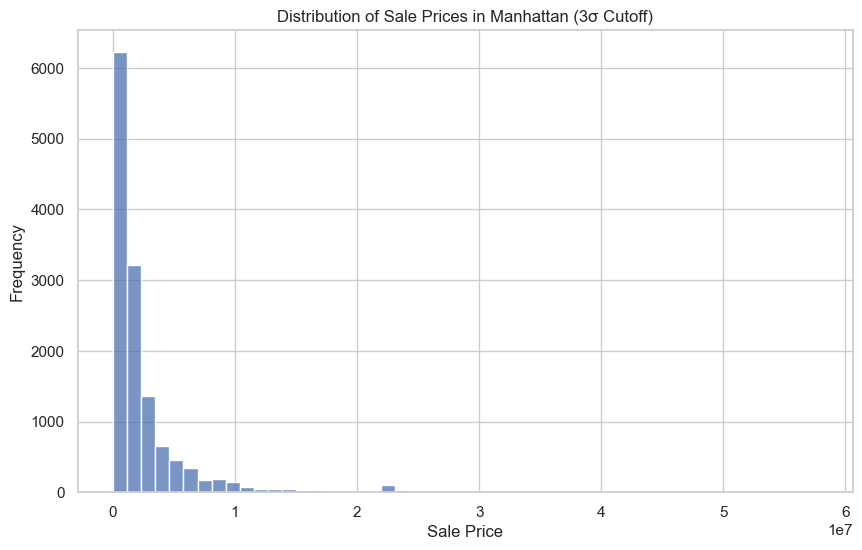

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


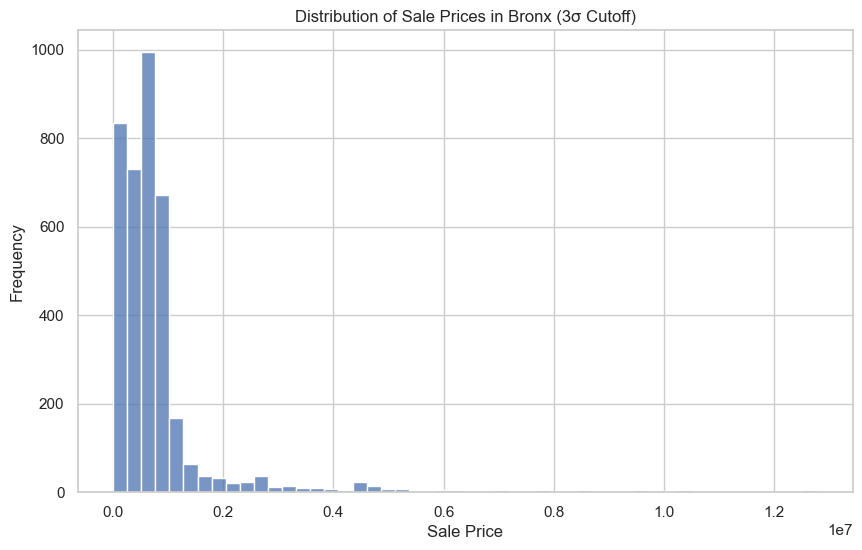

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


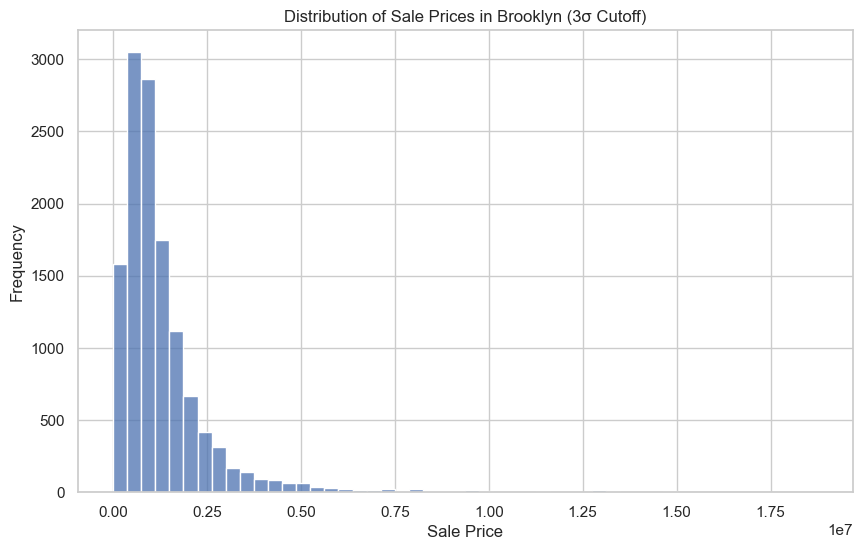

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


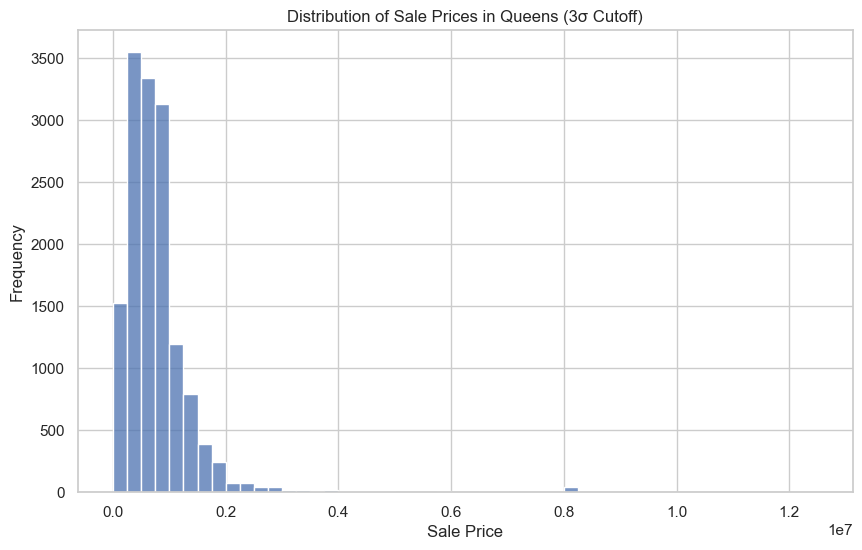

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


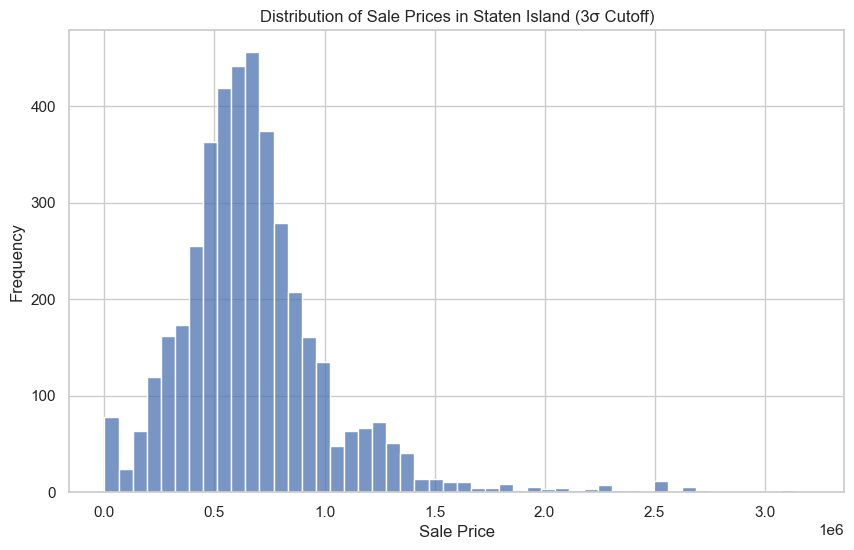

In [12]:
# Apply the function 'remove_outliers' to the 'sale_price' column of each borough's DataFrame
for borough, df in borough_dataframes.items():
    borough_dataframes[borough] = remove_outliers(df, 'sale_price')

# Here's an updated histogram with the outlier removal:
for borough, df in borough_dataframes.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(df['sale_price'], bins=50, kde=False)
    plt.xlabel('Sale Price')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Sale Prices in {borough} (3σ Cutoff)')
    plt.show()

#### 5.2.2 Boxplots

Boxplots are invaluable for comparing the spread and central tendency of sale prices across boroughs. They also highlight outliers, providing insights into price volatility and market dynamics. These comparisons can guide investment strategies and real estate development planning.


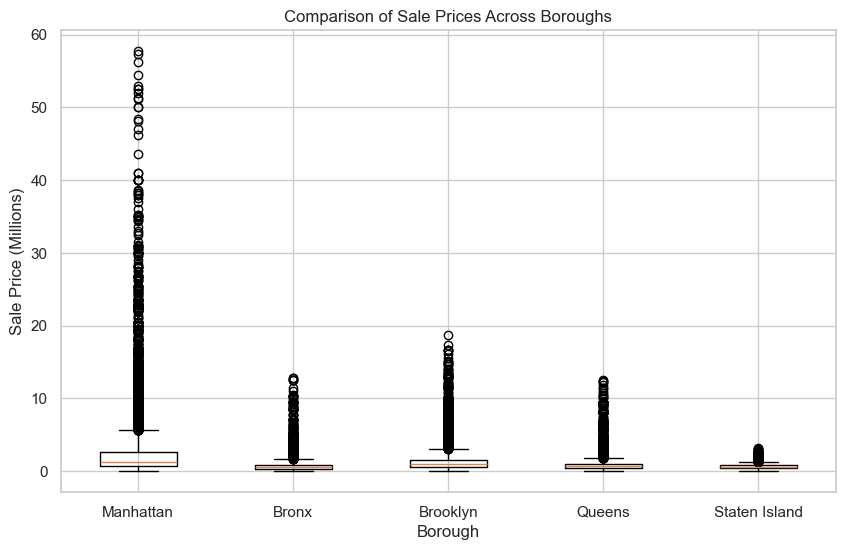

In [13]:
plt.figure(figsize=(10, 6))
data = [df['sale_price_millions'] for _, df in borough_dataframes.items()]
labels = list(borough_dataframes.keys())
plt.boxplot(data, labels=labels)
plt.xlabel('Borough')
plt.ylabel('Sale Price (Millions)')
plt.title('Comparison of Sale Prices Across Boroughs')
plt.show()

### 5.3 Volume Analysis

Analyzing sales volume over time offers insights into market trends, seasonality, and potential cycles in real estate activity. By examining the monthly sales volume, adjusted for partial data in the most recent month, we can uncover patterns that are essential for forecasting and strategic planning.


Time Series Analysis for Manhattan


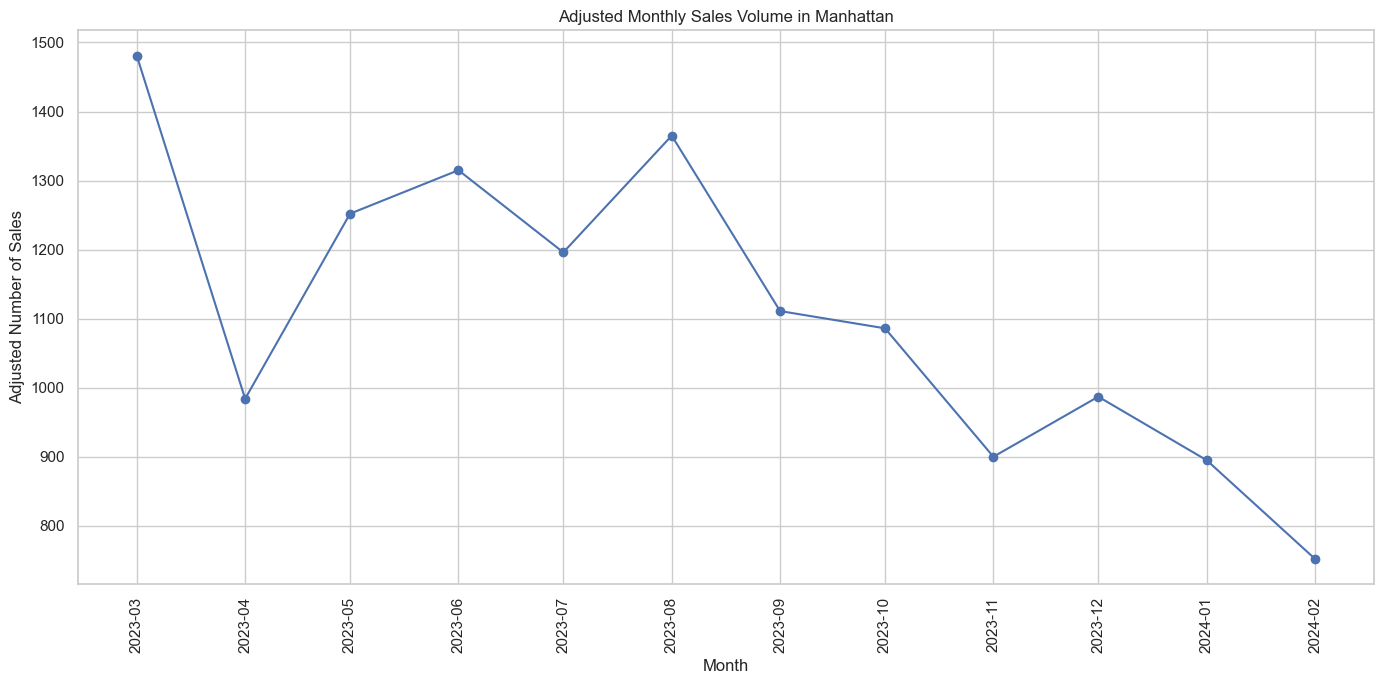

Time Series Analysis for Bronx


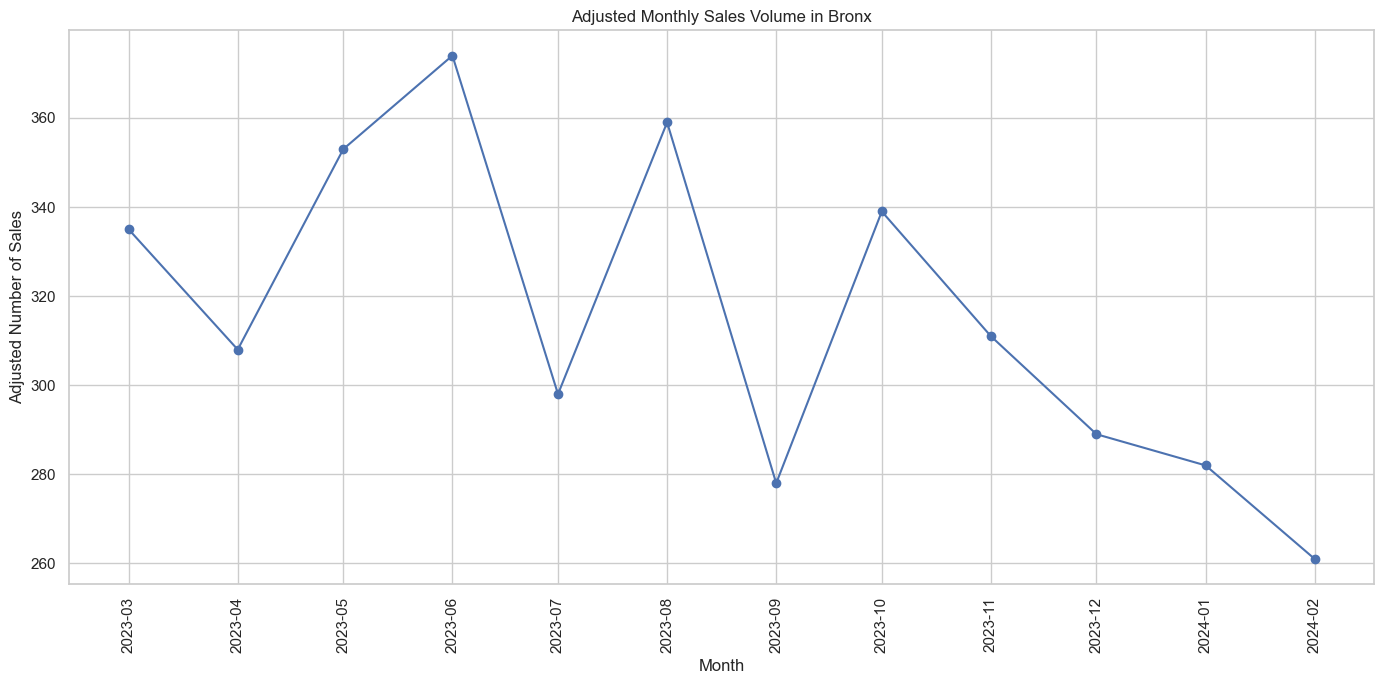

Time Series Analysis for Brooklyn


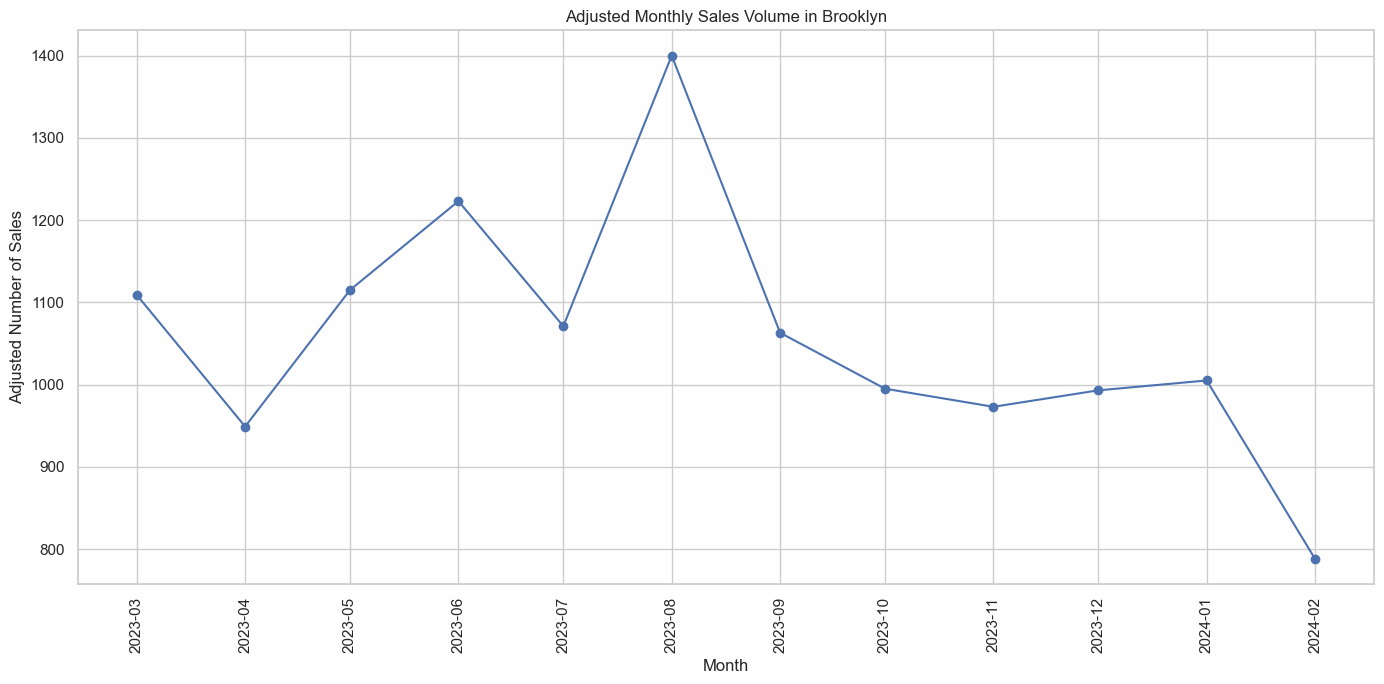

Time Series Analysis for Queens


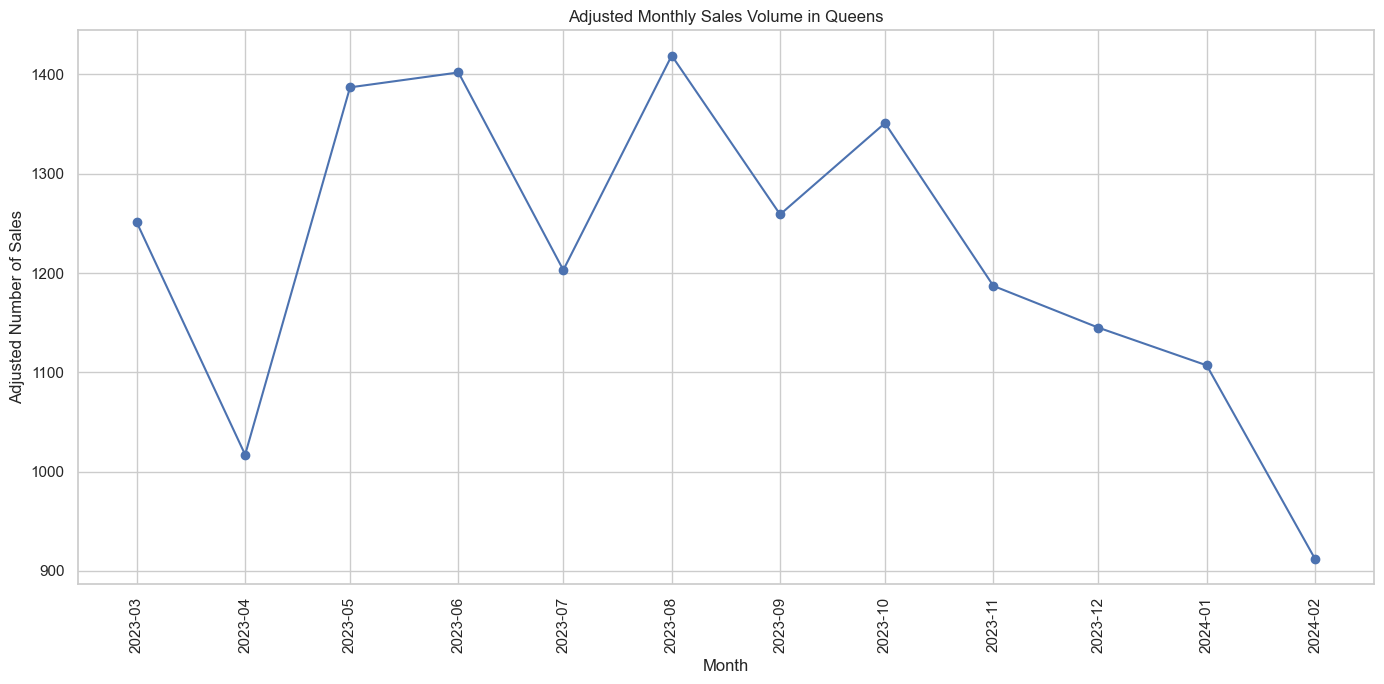

Time Series Analysis for Staten Island


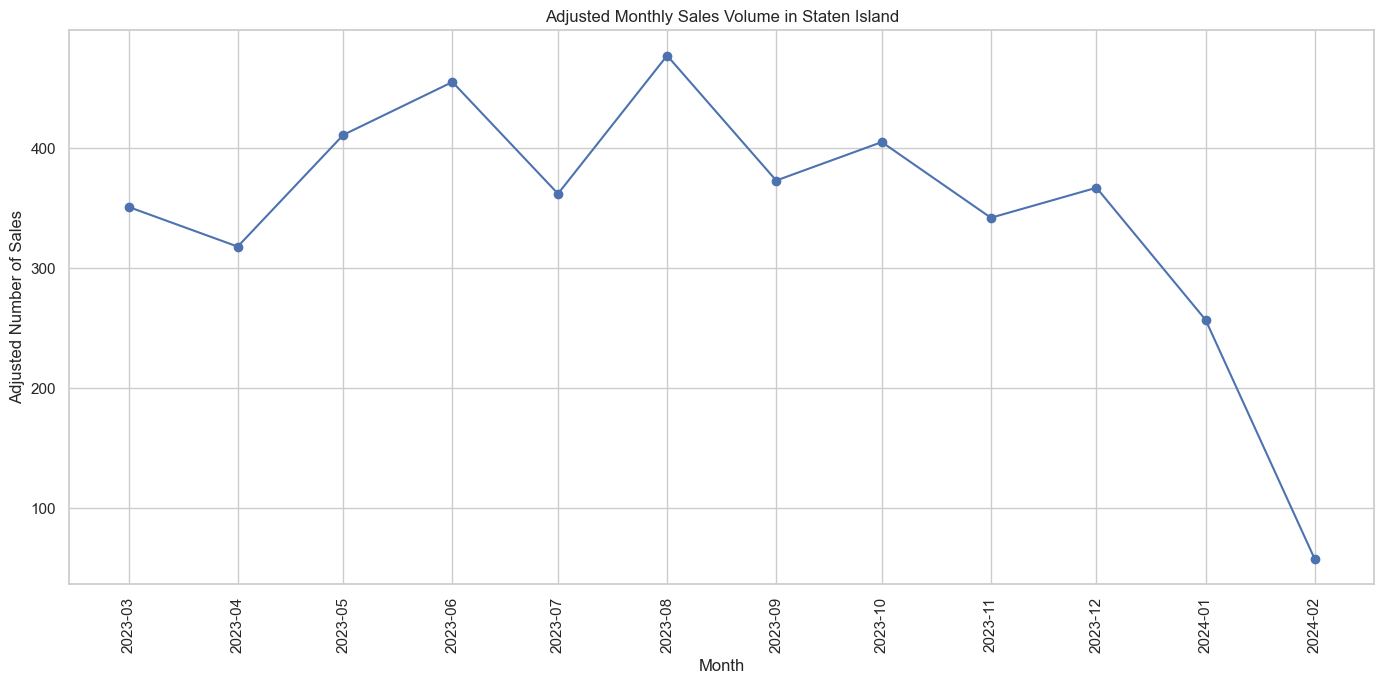

In [14]:
# Loop through each DataFrame and apply the time series preparation
for borough_name, df in borough_dataframes.items():
    print(f"Time Series Analysis for {borough_name}")
    time_series_df = prepare_time_series(df, 'sale_date')
    
    plt.figure(figsize=(14, 7))
    plt.plot(time_series_df['sale_month'], time_series_df['adjusted_sales_count'], '-o')
    
    plt.title(f"Adjusted Monthly Sales Volume in {borough_name}")
    plt.xlabel("Month")
    plt.ylabel("Adjusted Number of Sales")
    
    # Set major ticks format
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.xticks(rotation=90)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

### 5.4 Location Analysis

The impact of location on real estate dynamics cannot be overstated. Through detailed location analysis, including the use of bar charts to compare sales volumes by neighborhood and mapping techniques to visualize geographic patterns, we aim to uncover the influence of location on sale prices and volumes. This analysis is critical for identifying high-demand areas and understanding location-based market trends.


Top Neighborhoods by Sales Volume in Manhattan


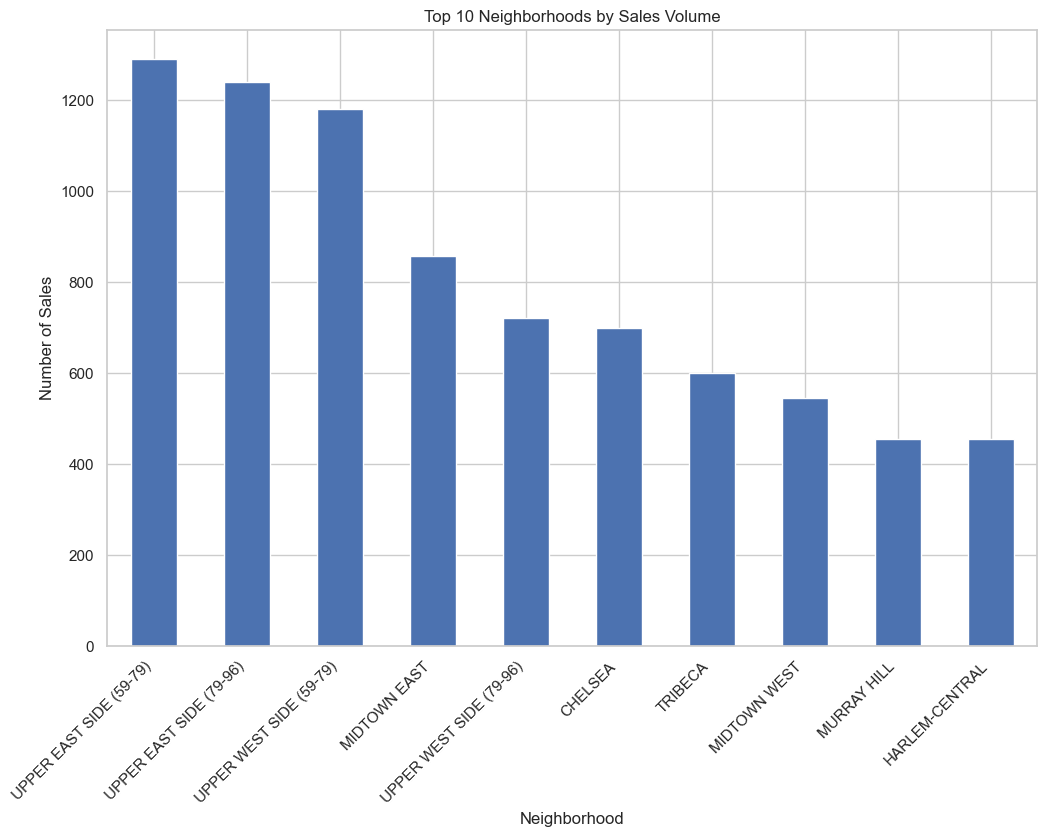

Top Neighborhoods by Sales Volume in Bronx


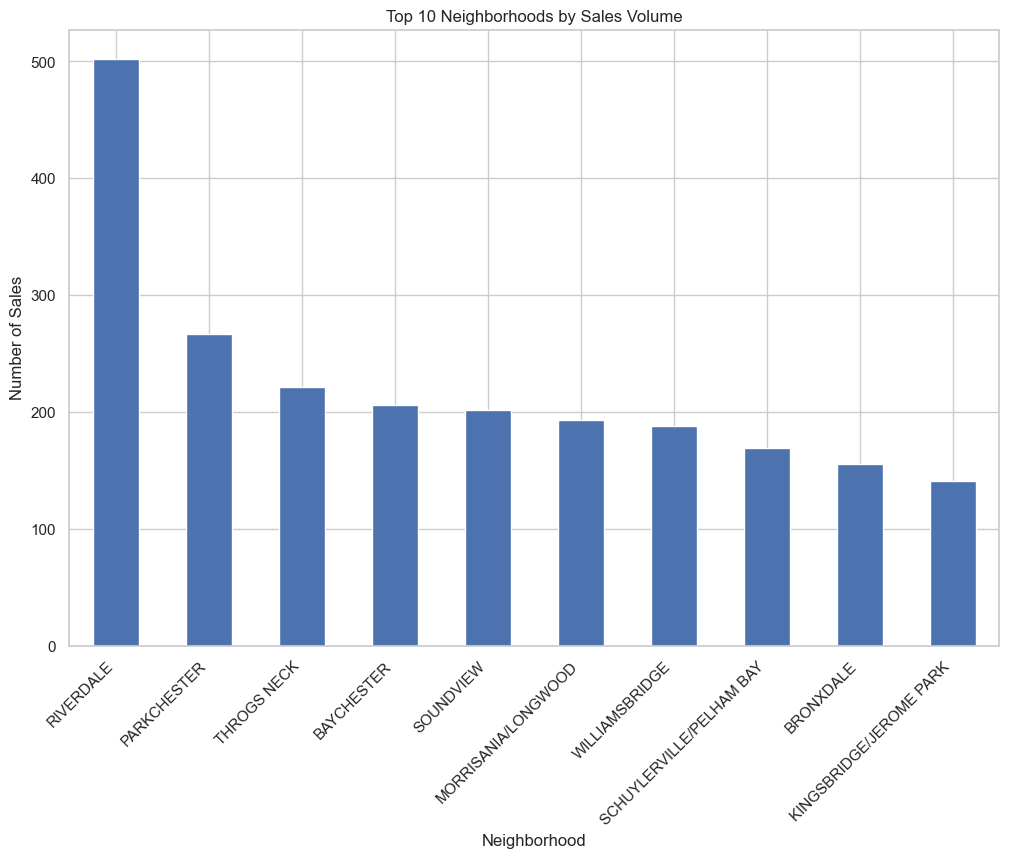

Top Neighborhoods by Sales Volume in Brooklyn


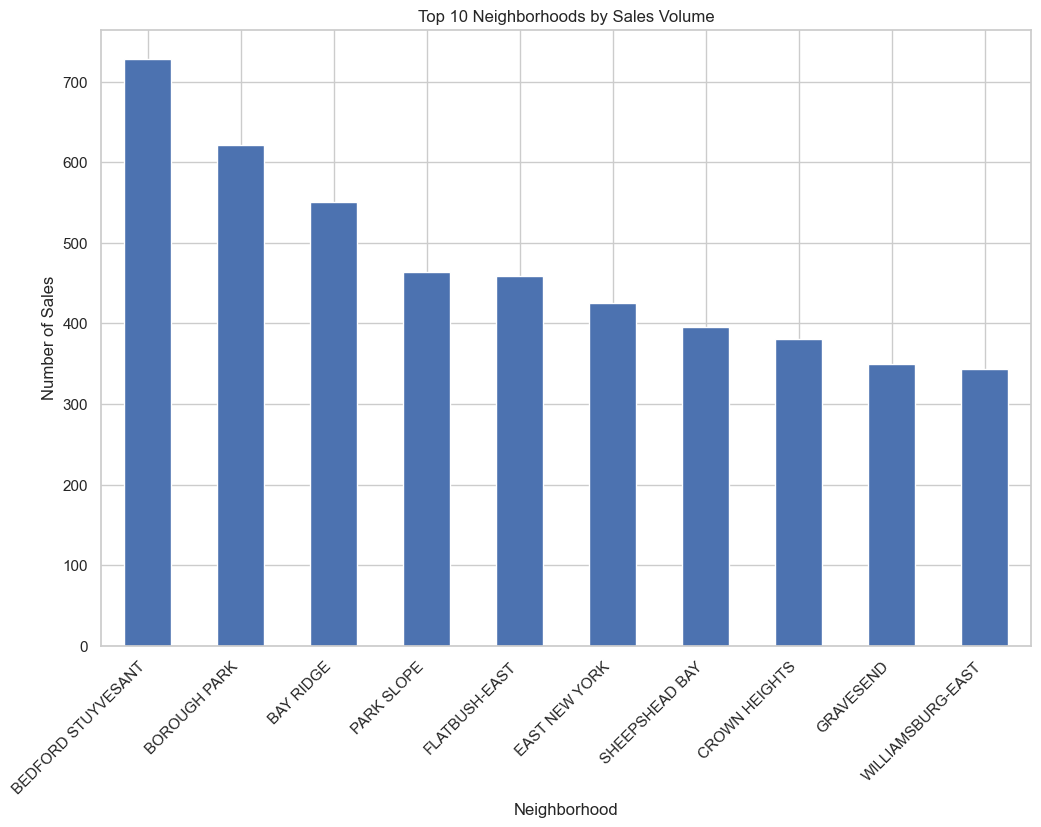

Top Neighborhoods by Sales Volume in Queens


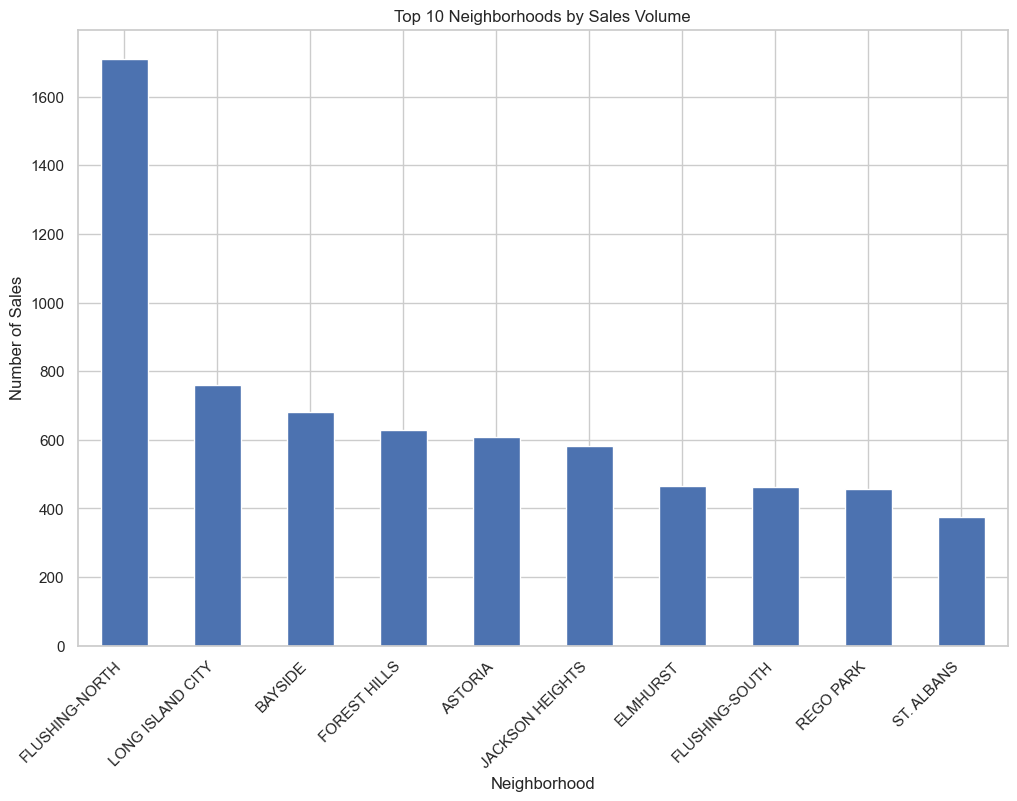

Top Neighborhoods by Sales Volume in Staten Island


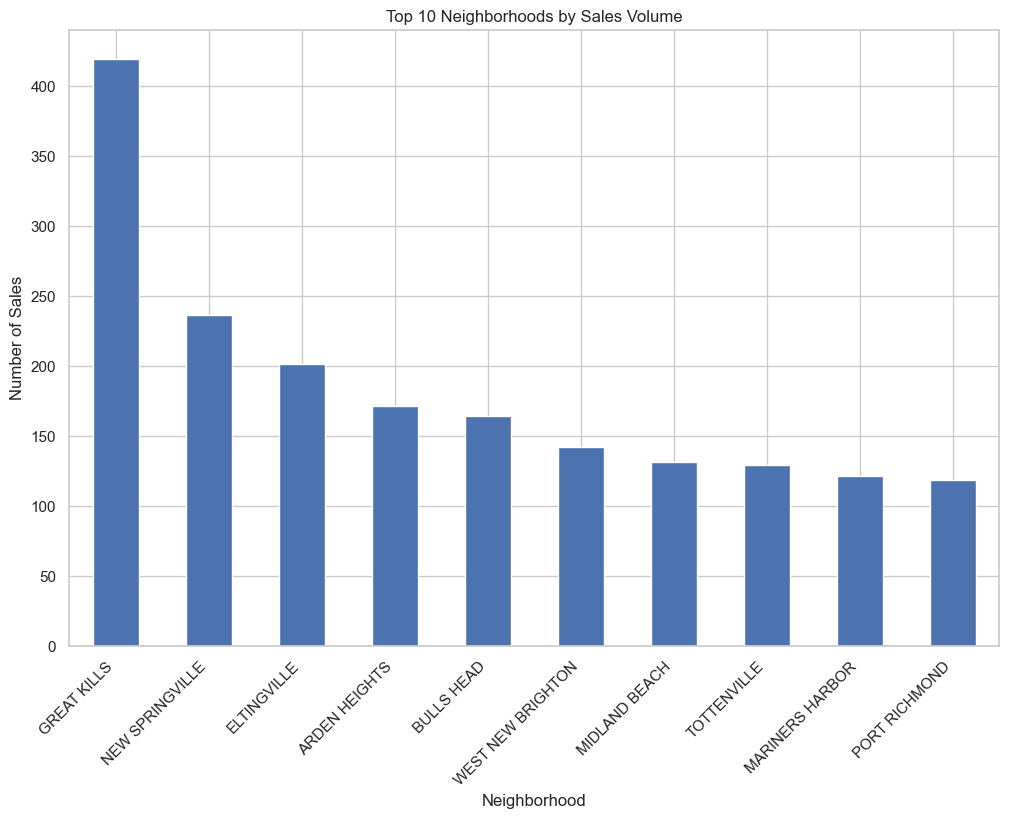

In [15]:
def plot_top_neighborhoods(df, n=10):
    """
    Plots bar charts showing the number of sales for the top N neighborhoods in a borough.
    
    Parameters:
    - df: DataFrame containing the sales data.
    - n: int, the number of top neighborhoods to display.
    
    This function sorts the neighborhoods by their sales volume and then plots the top N neighborhoods.
    It ensures that the plot is readable and not overcrowded with too many labels.
    """
    # Calculate sales count by neighborhood and sort in descending order
    top_neighborhoods = df['neighborhood'].value_counts().head(n)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    top_neighborhoods.plot(kind='bar')
    plt.title(f'Top {n} Neighborhoods by Sales Volume')
    plt.xlabel('Neighborhood')
    plt.ylabel('Number of Sales')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    plt.show()

# Apply the plotting function to each borough's DataFrame
for borough_name, df in borough_dataframes.items():
    print(f"Top Neighborhoods by Sales Volume in {borough_name}")
    plot_top_neighborhoods(df, n=10)


#### Geospatial Analysis and Visualization

Leveraging ZIP code geospatial data, we perform an aggregation to understand the mean sale price, total sales volume, and other key metrics by ZIP code. This aggregation is visualized on a map, enriched with interactive markers that provide detailed insights at the ZIP code level. This spatial representation of data is instrumental in recognizing geographic patterns and variances in the real estate market, offering valuable context for our Streamlit web application.


In [16]:
# Concatenate all borough DataFrames into a single DataFrame
all_data = pd.concat(borough_dataframes.values(), ignore_index=True)

# Load ZIP code geospatial data from uszipcodes_geodata.txt
geodata_df = pd.read_csv("../NYC_ZIP_geodata/uszipcodes_geodata.txt", dtype={'ZIP': str})

# Perform aggregation by zip code on all borough dataframes combined
zipcodes_agg = all_data.groupby('zip_code').agg({
    'sale_price': ['mean', 'sum'],  # Include sum to get total sales volume in dollars
    'residential_units': 'mean',  # Mean residential units per zip code
    'commercial_units': 'mean',  # Mean commercial units per zip code
    'total_units': 'mean',  # Mean total units per zip code
    'land_square_feet': 'mean',  # Mean land square feet per zip code
    'gross_square_feet': 'mean',  # Mean gross square feet per zip code
    'borough': 'count'  # Count to get total number of sales (sales volume)
}).reset_index()

# Rename columns for clarity
zipcodes_agg.columns = ['zip_code', 'mean_sale_price', 'total_sale_volume', 'mean_residential_units', 'mean_commercial_units', 'mean_total_units', 'mean_land_square_feet', 'mean_gross_square_feet', 'sales_count']

# Merge the ZIP code geospatial data with the aggregated data as before
zipcodes_agg = pd.merge(zipcodes_agg, geodata_df, left_on='zip_code', right_on='ZIP', how='left')

# Display the first few rows of the merged DataFrame
display(zipcodes_agg.sample(20))
display(zipcodes_agg.info())



,zip_code,mean_sale_price,total_sale_volume,mean_residential_units,mean_commercial_units,mean_total_units,mean_land_square_feet,mean_gross_square_feet,sales_count,ZIP,LAT,LNG
72,10467,7.943108e+05,150919055,3.990716,0.189988,4.174107,3509.556747,4190.634023,190,10467,40.869953,-73.865746
60,10455,1.184664e+06,61602523,5.191476,0.352470,5.483348,3946.505940,4382.680191,52,10455,40.814710,-73.908593
2,10003,2.331891e+06,1336173362,3.065123,1.839046,3.217449,3545.204748,19415.558479,573,10003,40.731829,-73.989181
68,10463,5.685438e+05,222869178,2.135297,0.242719,2.180787,7083.369784,5405.898002,392,10463,40.880678,-73.906540
73,10468,1.233048e+06,143033618,6.117952,0.266865,6.305395,4508.780211,7614.417381,116,10468,40.868093,-73.899730
32,10036,2.745339e+06,524359658,2.392096,1.691124,2.798935,6580.938698,33195.181281,191,10036,40.759260,-73.989860
87,11103,1.652579e+06,195004304,3.201183,0.316690,3.322492,2568.939396,3359.925794,118,11103,40.762574,-73.913447
138,11363,1.107662e+06,78644007,1.113473,0.015814,1.127465,6643.223109,2137.223732,71,11363,40.772616,-73.746526
78,10473,6.388056e+05,104125312,2.144897,0.035624,2.167516,3287.682609,3213.605985,163,10473,40.818690,-73.858474
12,10014,3.993595e+06,1705265159,3.495678,0.855226,3.554482,2852.566645,16529.924500,427,10014,40.734012,-74.006746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   zip_code                183 non-null    object 
 1   mean_sale_price         183 non-null    float64
 2   total_sale_volume       183 non-null    int64  
 3   mean_residential_units  182 non-null    float64
 4   mean_commercial_units   181 non-null    float64
 5   mean_total_units        182 non-null    float64
 6   mean_land_square_feet   181 non-null    float64
 7   mean_gross_square_feet  181 non-null    float64
 8   sales_count             183 non-null    int64  
 9   ZIP                     181 non-null    object 
 10  LAT                     181 non-null    float64
 11  LNG                     181 non-null    float64
dtypes: float64(8), int64(2), object(2)
memory usage: 17.3+ KB


None

In [17]:
# Load the GeoJSON file
with open("../NYC_ZIP_geodata/nyc-zip-code-tabulation-areas-polygons.geojson") as f:
    geo_data = json.load(f)

# Initialize a map centered around NYC
map_nyc = folium.Map(location=[40.693943, -73.985880], zoom_start=11)

# Overlay ZIP code boundaries and color them based on mean sales price
folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=zipcodes_agg,
    columns=['zip_code', 'mean_sale_price'],  # Corrected column name
    key_on='feature.properties.postalCode',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Mean Sale Price (in dollars)'
).add_to(map_nyc)

# Use a marker cluster to aggregate markers for each ZIP code
marker_cluster = MarkerCluster().add_to(map_nyc)

# Filter out rows with NaN values in 'LAT' or 'LNG' columns
zipcodes_agg_filtered = zipcodes_agg.dropna(subset=['LAT', 'LNG'])

# Loop through the filtered DataFrame to add markers to the map
for i, row in zipcodes_agg_filtered.iterrows():
    location = [row['LAT'], row['LNG']]
    tooltip = f"Zipcode:{row['zip_code']}<br> Click for more"
    popup_content = f"""
    <i>Mean sales price: </i> <br> <b>${int(row['mean_sale_price']):,}</b> <br>
    <i>Total sales volume in dollars: </i> <br> <b>${int(row['total_sale_volume']):,}</b> <br>
    <i>Sales volume (count): </i> <br> <b>{row['sales_count']}</b> <br>
    <i>Mean residential units: </i><b>{np.nan_to_num(row['mean_residential_units'], 0):.2f}</b><br>
    <i>Mean commercial units: </i><b>{np.nan_to_num(row['mean_commercial_units'], 0):.2f}</b><br>
    <i>Mean total units: </i><b>{np.nan_to_num(row['mean_total_units'], 0):.2f}</b><br>
    <i>Mean land square feet: </i><b>{int(np.nan_to_num(row['mean_land_square_feet'], 0)):,}</b><br>
    <i>Mean gross square feet: </i><b>{int(np.nan_to_num(row['mean_gross_square_feet'], 0)):,}</b><br>
    """

    folium.Marker(
        location,
        popup=folium.Popup(popup_content, max_width=300),
        tooltip=tooltip
    ).add_to(marker_cluster)

# Display the map
map_nyc

## 6. Insights and Conclusion

Throughout our exploratory data analysis of the NYC Rolling Sales data, we delved into various facets of the real estate market across the five boroughs. Our journey through summary statistics, price analyses, volume trends, and geospatial patterns has unearthed valuable insights that can inform stakeholders and guide the development of our Streamlit web application. Here are the key takeaways:

- **Price Trends and Distribution**: Our analysis highlighted significant variances in property sale prices across boroughs, with certain areas displaying higher median sale prices and wider price ranges. Identifying these trends helps pinpoint areas of high investment value and those with potential for future growth.

- **Volume Trends Over Time**: The time series analysis revealed patterns in sales volumes, including seasonal variations and overall market activity trends. Understanding these patterns is crucial for predicting market movements and planning investment strategies.

- **Location, Location, Location**: The geospatial analysis confirmed the adage that in real estate, location is everything. By visualizing sales data on a map, we identified hotspots of activity and areas with higher sale prices, providing a clear picture of the market's geographical dynamics.

- **Data-Driven Decisions**: The insights gained from this analysis are instrumental in making informed decisions regarding real estate investments, urban planning, and policy-making. By understanding market trends and dynamics, stakeholders can strategize more effectively.

### Recommendations for Further Research

While our analysis provides a solid foundation, the complexity and ever-changing nature of the real estate market call for ongoing research. Future studies could focus on:

- **Predictive Modeling**: Employing machine learning techniques to predict future sales prices and volumes based on historical data and market indicators.
- **Impact Analysis**: Investigating the impact of external factors, such as economic policies, interest rates, and demographic shifts, on the real estate market.
- **Micro-Market Analysis**: Conducting a deeper dive into specific neighborhoods or property types to uncover niche market trends and investment opportunities.

### Concluding Thoughts

The exploratory data analysis conducted in this notebook serves as a preliminary step towards developing a comprehensive understanding of the NYC real estate market. The insights derived will be invaluable in building a Streamlit web application that provides stakeholders with an interactive, data-driven view of the market. As we transition from data exploration to application development, our focus will remain on leveraging data to uncover opportunities and inform decisions within the vibrant landscape of NYC real estate.

